# SEP532 - 인공지능 이론과 실제 (2022 Spring)
## Deep Learning Practice 
#### Prof. Ho-Jin Choi
#### School of Computing, KAIST

---

# 7. Customization

## Function API 

### Building a model using functional API 

We're already familiar with the use of `keras.Sequential()` to create models. The _Functional API_ is **a way to create models that is more flexible than _Sequential_: it can handle models with non-linear topology, models with shared layers, and models with multiple inputs or outputs.**

It's based on the idea that a deep learning model is usually a directed acyclic graph (DAG) of layers. The Functional API a set of tools for building graphs of layers.

Consider the following model:
``` python
(input: 784-dimensional vectors)
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (10 units, softmax activation)]
       ↧
(output: probability distribution over 10 classes)
```

It's a simple graph of 3 layers.

To build this model with the functional API, you would start by creating an _input node_:

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

In [2]:
from tensorflow import keras
# Build an input node
inputs = keras.Input(shape=(784,))

if the input shape is a (32, 32, 3) image, we can build the input node as follows: 
``` python 
img_inputs = keras.Input(shape=(32, 32, 3))
```
Here we just specify the shape of our data: 784-dimensional vectors. Note that the batch size is always omitted, **we only specify the shape of each sample.**

In [3]:
inputs.shape

TensorShape([None, 784])

In [4]:
inputs.dtype

tf.float32

You create a new node in the graph of layers by calling a layer on this inputs object:

In [5]:
from tensorflow.keras import layers

# define a new dense layer
dense = layers.Dense(64, activation='relu')

# build the dense layer to the graph of layers
# by feeding outputs of input layer to the dense layer as an input 
# ==> Layer call 
x = dense(inputs)

The _"layer call"_ action is like drawing an arrow from "inputs" to this layer we created. We're "passing" the inputs to the dense layer, and out we get x.

Let's add a few more layers to our graph of layers:

In [6]:
# build more layers 
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

At this point, we can create a Model by specifying its inputs and outputs in the graph of layers:

In [7]:
from tensorflow.keras import Model

# create a model 
model = keras.Model(inputs=inputs, outputs=outputs)

To recap, here is our full model definition process:

``` python
inputs = keras.Input(shape=(784,), name='img')
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='mnist_model')
```

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


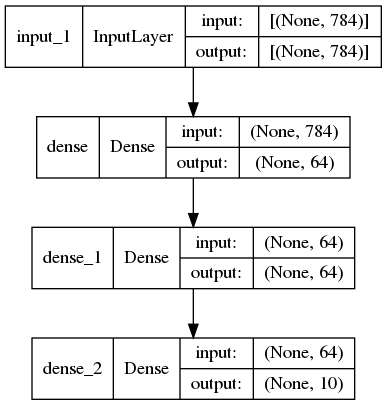

In [9]:
tf.keras.utils.plot_model(model, 'my_first_model.png', show_shapes=True)

In [10]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

Epoch 1/5
750/750 [==============================] - 2s 1ms/step - loss: 0.3568 - accuracy: 0.8980 - val_loss: 0.1878 - val_accuracy: 0.9462
Epoch 2/5
750/750 [==============================] - 1s 1ms/step - loss: 0.1572 - accuracy: 0.9539 - val_loss: 0.1461 - val_accuracy: 0.9570
Epoch 3/5
750/750 [==============================] - 1s 1ms/step - loss: 0.1157 - accuracy: 0.9653 - val_loss: 0.1197 - val_accuracy: 0.9646
Epoch 4/5
750/750 [==============================] - 1s 1ms/step - loss: 0.0895 - accuracy: 0.9735 - val_loss: 0.1122 - val_accuracy: 0.9668
Epoch 5/5
750/750 [==============================] - 1s 1ms/step - loss: 0.0744 - accuracy: 0.9776 - val_loss: 0.1143 - val_accuracy: 0.9669
Test loss: 0.10217183828353882
Test accuracy: 0.968500018119812


### Manipulating complex graph topologies

The **functional API makes it easy to manipulate multiple inputs and outputs**. This cannot be handled with the Sequential API.

Here's a simple example.

Let's say you're building a system for ranking custom issue tickets by priority and routing them to the right department.

You model will have 3 inputs:
- Title of the ticket (text input)
- Text body of the ticket (text input)
- Any tags added by the user (categorical input)

It will have two outputs:
- Priority score between 0 and 1 (scalar sigmoid output)
- The department that should handle the ticket (softmax output over the set of departments)

Let's built this model in a few lines with the Functional API.

In [11]:
num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(shape=(None,), name='title')  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name='body')  # Variable-length sequence of ints
tags_input = keras.Input(shape=(num_tags,), name='tags')  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)
# input shape of embeeding layer: (batch_size, input_length)
# output shape of embedding layer: (batch_size, input_length, embedding_dim)

# Reduce sequence of embedded words in the title into 
# a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into 
# a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, activation='sigmoid', name='priority')(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, activation='softmax', name='department')(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(inputs=[title_input, body_input, tags_input],
                    outputs=[priority_pred, department_pred])

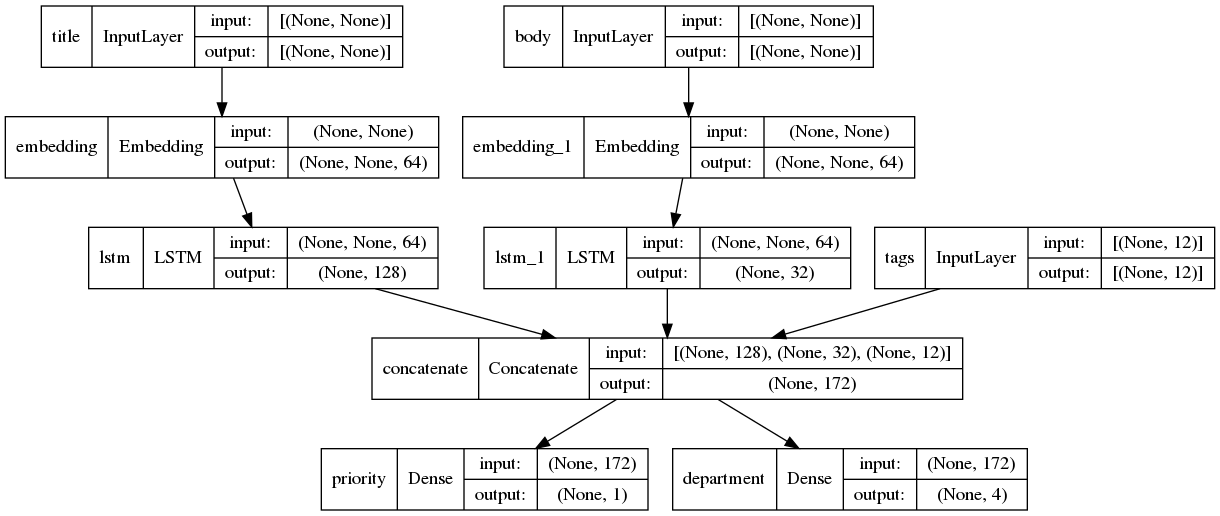

In [12]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

When compiling this model, we can **assign different losses to each output.** You can even **assign different weights to each loss**, to modulate their contribution to the total training loss. (e.g., Be able to adjust weight of important loss to affect learning more)

In [13]:
# specify the loss using the names of output layers

model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss={'priority': 'binary_crossentropy',
                    'department': 'categorical_crossentropy'},
              loss_weights=[1., 0.2])

"""
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss=['binary_crossentropy', 'categorical_crossentropy'],
              loss_weights=[1., 0.2])
"""

"\nmodel.compile(optimizer=keras.optimizers.RMSprop(1e-3),\n              loss=['binary_crossentropy', 'categorical_crossentropy'],\n              loss_weights=[1., 0.2])\n"

## Customizing the loss and metric

### Loss customization
There are two ways to provide **custom losses with Keras**. The first example creates a function that accepts inputs `y_true` and `y_pred`. The following example shows a loss function that computes the average distance between the real data and the predictions:

``` python
# define a custom loss function
def basic_loss_function(y_true, y_pred):
    return tf.math.reduce_mean(y_true - y_pred)

model = ...

model.compile(optimizer=keras.optimizers.Adam(),
              loss=basic_loss_function,
              metrics=['accuracy'])

```

Another method is to use the `tf.keras.losses.Loss` class by implementing the follwing methods: 

- `__init__(self)`: Accept parameters to pass during the call of your loss function
- `call(self, y_true, y_pred)`: Use the targets (`y_true`) and the model predictions (`y_pred`) to compute the model's loss

The following example shows how to implement a `WeightedCrossEntropy` loss function that calculates a BinaryCrossEntropy loss, where the loss of a certain class or the whole function can be modified by a scalar.


```python 

class WeightedBinaryCrossEntropy(keras.losses.Loss):
    """
    Args:
      pos_weight: Scalar to affect the positive labels of the loss function.
      weight: Scalar to affect the entirety of the loss function.
      from_logits: Whether to compute loss form logits or the probability.
      reduction: Type of tf.keras.losses.Reduction to apply to loss.
      name: Name of the loss function.
    """
    def __init__(self, pos_weight, weight, from_logits=False,
                 reduction=keras.losses.Reduction.AUTO,
                 name='weighted_binary_crossentropy'):
        super(WeightedBinaryCrossEntropy, self).__init__(reduction=reduction,
                                                         name=name)
        self.pos_weight = pos_weight
        self.weight = weight
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        if not self.from_logits:
            x_1 = y_true * self.pos_weight * -tf.math.log(y_pred + 1e-6)
            x_2 = (1 - y_true) * -tf.math.log(1 - y_pred + 1e-6)
            return tf.add(x_1, x_2) * self.weight 

        # Use built in function
        return tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, self.pos_weight) * self.weight

model = ...
    
# use the loss function you defined
model.compile(optimizer=keras.optimizers.Adam(),
              loss=WeightedBinaryCrossEntropy(0.5, 2))

```

### Metric customization

We can define custom metrics by subclassing the Metric class**. You will need to implement 4 methods:
- `__init__(self)`: state variables for your metric.
- `update_state(self, y_true, y_pred, sample_weight=None)`: the targets `y_true` and the model predictions `y_pred` to update the state variables.
- `result(self)`: the state variables to compute the final results.
- `reset_states(self)`: reinitializes the state of the metric.

State update and results computation are kept separate (in `update_state()` and `result()`, respectively) because in some cases, results computation might be very expensive, and would only be done periodically.

Here's a simple example showing how to implement a `CatgoricalTruePositives` metric, that counts how many samples where correctly classified as belonging to a given class:


``` python

class CatgoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name='categorical_true_positives', **kwargs):
        super(CatgoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, 'int32') == tf.cast(y_pred, 'int32')
        values = tf.cast(values, 'float32')
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, 'float32')
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))
        
    def result(self):
        return self.true_positives
    
    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.)

model = ...
        
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[CatgoricalTruePositives()])

model.fit(x_train, y_train,
          batch_size=64,
          epochs=3)

```

## Subclassing and Automatic differentiation

### Subclassing

Building below model using `Sequential`.
``` python
(input: 784-dimensional vectors)
       ↧
[Dense (64 units, relu activation)]
       ↧
[Dense (10 units, softmax activation)]
       ↧
(output: probability distribution over 10 classes)
```

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Flatten(input_shape=(784,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                50240     
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


Building a model using subclassing:
- `init`: definie the model structure 
- `call`: calcuate the forward passing (in the form of functional API)

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

class MyClassifier(tf.keras.Model):
    def __init__(self):
        super(MyClassifier, self).__init__()
        self.input_layer = layers.Flatten()
        self.hidden_layer = layers.Dense(64, activation='relu', name='dense_1')
        self.output_layer = layers.Dense(10, activation='softmax', name='predictions')
        
    def call(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        outputs = self.output_layer(x)
        return outputs    

my_model = MyClassifier()

In [16]:
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

my_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

my_model.fit(x_train, y_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 2s 927us/step - loss: 1.3843 - accuracy: 0.6574
Epoch 2/3
1875/1875 [==============================] - 2s 939us/step - loss: 0.5962 - accuracy: 0.8556
Epoch 3/3
1875/1875 [==============================] - 2s 943us/step - loss: 0.4407 - accuracy: 0.8834


In [17]:
my_model.evaluate(x_test, y_test, verbose=0)

[0.3938450515270233, 0.8938999772071838]

### Automatic differentiation Using GradientTape
TensorFlow provides the [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) API for _automatic differentiation_ - computing the gradient of a computation with respect to its input variables. 

Tensorflow "records" all operations executed inside the context of a `tf.GradientTape` onto a _"tape"_. Tensorflow then uses that tape and the gradients associated with each recorded operation to compute the gradients of a "recorded" computation using reverse mode differentiation.

For example:
- [`tf.GradientTape.watch(tensor)`](https://www.tensorflow.org/api_docs/python/tf/GradientTape#watch): Ensures that tensor is being traced by this tape.
- [`tf.GradientTape.gradient(target,source)`](https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient): Computes the gradient using operations recorded in context of this tape.
    - `target`: Tensor (or list of tensors) to be differentiated.
    - `source`: A list or nested structure of Tensors or Variables. `target` will be differentiated against elements in `sources`.

In [19]:
x = tf.ones((2, 2))
# x = [[1, 1]
#      [1, 1]]

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.reduce_sum(x) # 4
    z = tf.multiply(y, y) # y^2 

# Use the tape to compute the derivative of z with respect to the
# intermediate value y.
# z = y^2
dz_dy = tape.gradient(z, x) 
print(dz_dy)

tf.Tensor(
[[8. 8.]
 [8. 8.]], shape=(2, 2), dtype=float32)


You can also request gradients of the output with respect to intermediate values computed during a "recorded" `tf.GradientTape` context.

In [20]:
x = tf.constant(3.0)

with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    y = x * x # x^2 
    z = y * y # y^2 = x^4

dy_dx = tape.gradient(y, x)  # 6.0
print(dy_dx)
     
dz_dx = tape.gradient(z, x)  # 108.0 (4*x^3 at x = 3)
print(dz_dx)

del tape  # Drop the reference to the tape

tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(108.0, shape=(), dtype=float32)


### Training the model with GradientTape

Calling a model inside a `GradientTape` scope **enables you to retrieve the gradients of the trainable weights** of the layer with respect to a loss value. Using an optimizer instance, you can **use these gradients to update these variables (which you can retrieve using model.trainable_weights)**.

Let's reuse our MNIST model using subclassing and let's train it using mini-batch gradient with a custom training loop.

In [26]:
from tensorflow import keras
from tensorflow.keras import layers

class MyClassifier(tf.keras.Model):
    def __init__(self):
        super(MyClassifier, self).__init__()
        self.input_layer = layers.Flatten()
        self.hidden_layer = layers.Dense(64, activation='relu', name='dense_1')
        self.output_layer = layers.Dense(10, activation='softmax', name='predictions')
        
    def call(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        outputs = self.output_layer(x)
        return outputs
    
my_model = MyClassifier()

In [22]:
# Load a toy dataset for the sake of this example
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are Numpy arrays)
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [23]:
# Prepare the training dataset.
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [24]:
# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy()

In [25]:
# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
train_loss = tf.keras.metrics.Mean(name='train_loss')

val_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_loss = tf.keras.metrics.Mean(name='val_loss')

In [27]:
# Iterate over epochs.
for epoch in range(3):
    print('\n\nStart of epoch %d' % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables autodifferentiation.
        with tf.GradientTape() as tape:
            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = my_model(x_batch_train)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)
                        

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, my_model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, my_model.trainable_weights))
        
        
        # Update training metric.
        train_acc_metric(y_batch_train, logits)
        train_loss(loss_value)

        # Log every 200 batches.
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step + 1) * 64))
            
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("-------------------------------------------")
    print('Training loss: %.3f | acc over epoch: %s' % (train_loss.result(), float(train_acc),))
        
        
    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = my_model(x_batch_val)
        v_loss = loss_fn(y_batch_val, val_logits)
        
        val_loss(v_loss)
        
        # Update val metrics
        val_acc_metric(y_batch_val, val_logits)
        
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("-------------------------------------------")
    print('Validation avg loss: %.3f | acc: %s' % (val_loss.result(), float(val_acc),))
    
    # Reset the metrics for the next epoch
    train_acc_metric.reset_states()
    train_loss.reset_states()

    val_acc_metric.reset_states()
    val_loss.reset_states()



Start of epoch 0
Training loss (for one batch) at step 0: 2.430046558380127
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.2361326217651367
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.951197862625122
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.9387059211730957
Seen so far: 38464 samples
-------------------------------------------
Training loss: 2.049 | acc over epoch: 0.3449600040912628
-------------------------------------------
Validation avg loss: 1.738 | acc: 0.5853000283241272


Start of epoch 1
Training loss (for one batch) at step 0: 1.7981845140457153
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.578611135482788
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.5459768772125244
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.4077403545379639
Seen so far: 38464 samples
-------------------------------------------
Training loss: 1.527

## Custom layer

### tf.keras.Layer class
The main data structure you'll work with is the Layer. A layer encapsulates both a **state (the layer's _"weights"_)** and a transformation from inputs to outputs **(a "call", the layer's _forward pass_)**.

Here's a densely-connected layer. It has a state: the variables `w` and `b`.

In [29]:
from tensorflow.keras import layers

class Linear(layers.Layer):
    def __init__(self, units=32, input_dim=32):
        super(Linear, self).__init__()
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(initial_value=w_init(shape=(input_dim, units),
                                                  dtype='float32'),
                                                  trainable=True)
        
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(initial_value=b_init(shape=(units,),
                                                  dtype='float32'),
                                                  trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
x = tf.ones((2, 2))
linear_layer = Linear(4, 2)
y = linear_layer(x)
print(y)

tf.Tensor(
[[ 0.06654245 -0.15318133  0.00718249 -0.05488218]
 [ 0.06654245 -0.15318133  0.00718249 -0.05488218]], shape=(2, 4), dtype=float32)


Note that the weights `w` and `b` are automatically tracked by the layer upon being set as layer attributes:

In [30]:
print(linear_layer.weights) # linear_layer.w

[<tf.Variable 'Variable:0' shape=(2, 4) dtype=float32, numpy=
array([[ 0.05738373, -0.02922972,  0.03296256, -0.07645816],
       [ 0.00915871, -0.12395161, -0.02578007,  0.02157598]],
      dtype=float32)>, <tf.Variable 'Variable:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>]


In [31]:
print([linear_layer.b])

[<tf.Variable 'Variable:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>]


Note you also have access to a quicker shortcut for **adding weight to a layer**: the `add_weight` method:

In [32]:
class Linear(layers.Layer):
    def __init__(self, units=32, input_dim=32):
        super(Linear, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

x = tf.ones((2, 2))
linear_layer = Linear(4, 2)
y = linear_layer(x)
print(y)

tf.Tensor(
[[ 0.04320239  0.03053737 -0.1708824   0.1946851 ]
 [ 0.04320239  0.03053737 -0.1708824   0.1946851 ]], shape=(2, 4), dtype=float32)


#### Layers can have non-trainable weights
Besides trainable weights, you can add _non-trainable weights_ to a layer as well. Such weights are meant not to be taken into account during backpropagation, when you are training the layer.

Here's how to add and use a non-trainable weight:

In [33]:
class ComputeSum(layers.Layer):
    def __init__(self, input_dim):
        super(ComputeSum, self).__init__()
        self.total = tf.Variable(initial_value=tf.zeros((input_dim,)),
                                 trainable=False)
    def call(self, inputs):
        self.total.assign_add(tf.reduce_sum(inputs, axis=0))
        return self.total

x = tf.ones((2, 2))
my_sum = ComputeSum(2)
y = my_sum(x)
print(y.numpy())
y = my_sum(x)
print(y.numpy())

[2. 2.]
[4. 4.]


It's part of `layer.weights`, but it gets categorized as a non-trainable weight:

In [34]:
print('weights:', len(my_sum.weights))
print('non-trainable weights:', len(my_sum.non_trainable_weights))

# It's not included in the trainable weights:
print('trainable_weights:', my_sum.trainable_weights)

weights: 1
non-trainable weights: 1
trainable_weights: []


**Best practice: deferring weight creation until the shape of the inputs is known** <br>
In the logistic regression example above, our `Linear` layer took an `input_dim` argument that was used to compute the shape of the weights `w` and `b` in `__init__`:
```python
class Linear(layers.Layer):
  def __init__(self, units=32, input_dim=32):
      super(Linear, self).__init__()
      self.w = self.add_weight(shape=(input_dim, units),
                               initializer='random_normal',
                               trainable=True)
      self.b = self.add_weight(shape=(units,),
                               initializer='zeros',
                               trainable=True)
```

In many cases, **you may not know in advance the size of your inputs**, and you **would like to lazily create weights when that value becomes known**, some time after instantiating the layer.

In the Keras API, we recommend creating layer weights in the `build(inputs_shape)` method of your layer. Like this:

In [35]:
class Linear(layers.Layer):
    def __init__(self, units=32):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        # To multiply inputs * weight. i.e., input_shape = (x, y) / weight (y, u) -> ? have to be `y` dim
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='random_normal',
                                 trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

The **`__call__` method of your layer will automatically run build the first time it is called**. You now have a layer that's lazy and easy to use:

In [ ]:
linear_layer = Linear(32)  # At instantiation, we don't know on what inputs this is going to get called
y = linear_layer(x)  # The layer's weights are created dynamically the first time the layer is called

#### Layers are recursively composable
If you assign a Layer instance as attribute of another Layer, the outer layer will start tracking the weights of the inner layer.

We recommend creating such sublayers in the `__init__` method (since the sublayers will typically have a build method, they will be built when the outer layer gets built).

In [ ]:
# Let's assume we are reusing the Linear class
# with a `build` method that we defined above.

class MLPBlock(layers.Layer):
    def __init__(self):
        super(MLPBlock, self).__init__()
        self.linear_1 = Linear(32)
        self.linear_2 = Linear(32)
        self.linear_3 = Linear(1)

    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        return self.linear_3(x)


mlp = MLPBlock()
y = mlp(tf.ones(shape=(3, 64)))  # The first call to the `mlp` will create the weights
print('weights:', len(mlp.weights))
print('trainable weights:', len(mlp.trainable_weights))

#### Examples of using custom layers: Building Models 
In general, you will **use the `Layer` class to define inner computation blocks, and will use the `Model` class to define the outer model** -- the object you will train.

For instance, in a ResNet50 model, you would have several ResNet blocks subclassing `Layer`, and a single `Model` encompassing the entire ResNet50 network.

Effectively, the "Layer" class corresponds to what we refer to in the literature as a "layer" (as in "convolution layer" or "recurrent layer") or as a "block" (as in "ResNet block" or "Inception block").

Meanwhile, the "Model" class corresponds to what is referred to in the literature as a "model" (as in "deep learning model") or as a "network" (as in "deep neural network").

For instance, we could take our mini-resnet example above, and use it to build a Model that we could train with `fit()`, and that we could save with `save_weights`:

```python
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.Conv2D(64, 3, activation='relu')(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_1_output)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_2_output)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
block_3_output = layers.add([x, block_2_output])
```
--> Create a `Layer` class based on subclassing <br>
--> Then, we can make some instances for `ResnetBlock()`

```python
class ResNet(tf.keras.Model):
    def __init__(self):
        super(ResNet, self).__init__()
        self.block_1 = ResNetBlock()
        self.block_2 = ResNetBlock()
        self.global_pool = layers.GlobalAveragePooling2D()
        self.classifier = Dense(num_classes)

    def call(self, inputs):
        x = self.block_1(inputs)
        x = self.block_2(x)
        x = self.global_pool(x)
        return self.classifier(x)


resnet = ResNet()
dataset = ...
resnet.fit(dataset, epochs=10)
resnet.save_weights(filepath)
```

#### Putting it all together: An end-to-end example
Here's what you've learned so far: 
- A `Layer` encapsulate a state (created in `__init__` or `build`) and some computation (in `call`). 
- Layers can be recursively nested to create new, bigger computation blocks. 
- Layers can create and track losses (typically regularization losses).
- The outer container, the thing you want to train, is a `Model`. A `Model` is just like a `Layer`, but with added training and serialization utilities.

Let's put all of these things together into an end-to-end example: we're going to implement a Variational AutoEncoder (VAE). We'll train it on MNIST digits.

Our VAE will be a subclass of `Model`, built as a nested composition of layers that subclass Layer. It will feature a regularization loss (KL divergence).

<img src=https://lilianweng.github.io/lil-log/assets/images/vae-gaussian.png>

In [36]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [37]:
class Encoder(layers.Layer):
    """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

    def __init__(self,
               latent_dim=32,
               intermediate_dim=64,
               name='encoder',
               **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation='relu')
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [38]:
class Decoder(layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""

    def __init__(self,
               original_dim,
               intermediate_dim=64,
               name='decoder',
               **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation='relu')
        self.dense_output = layers.Dense(original_dim, activation='sigmoid')

    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)

In [39]:
class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(self,
               original_dim,
               intermediate_dim=64,
               latent_dim=32,
               name='autoencoder',
               **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim,
                               intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = - 0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed

In [40]:
original_dim = 784
vae = VariationalAutoEncoder(original_dim, 64, 32)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

loss_metric = tf.keras.metrics.Mean()

(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

In [41]:
# Iterate over epochs.
for epoch in range(3):
    print('Start of epoch %d' % (epoch,))

    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            reconstructed = vae(x_batch_train)
            # Compute reconstruction loss
            loss = mse_loss_fn(x_batch_train, reconstructed)
            loss += sum(vae.losses)  # Add KLD regularization loss

        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        loss_metric(loss)

        if step % 100 == 0:
            print('step %s: mean loss = %s' % (step, loss_metric.result()))

Start of epoch 0
step 0: mean loss = tf.Tensor(0.32220107, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(0.12527098, shape=(), dtype=float32)
step 200: mean loss = tf.Tensor(0.09905326, shape=(), dtype=float32)
step 300: mean loss = tf.Tensor(0.08907544, shape=(), dtype=float32)
step 400: mean loss = tf.Tensor(0.08416632, shape=(), dtype=float32)
step 500: mean loss = tf.Tensor(0.08081143, shape=(), dtype=float32)
step 600: mean loss = tf.Tensor(0.07869195, shape=(), dtype=float32)
step 700: mean loss = tf.Tensor(0.0770916, shape=(), dtype=float32)
step 800: mean loss = tf.Tensor(0.075935125, shape=(), dtype=float32)
step 900: mean loss = tf.Tensor(0.07491907, shape=(), dtype=float32)
Start of epoch 1
step 0: mean loss = tf.Tensor(0.07462288, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(0.073974535, shape=(), dtype=float32)
step 200: mean loss = tf.Tensor(0.073476546, shape=(), dtype=float32)
step 300: mean loss = tf.Tensor(0.07299976, shape=(), dtype=float32)
st